# QEvasion – Transformer Fine-tuning (Clarity & Evasion)

In this notebook we fine-tune a pretrained transformer encoder on the QEvasion dataset
for the two main tasks:

- **Task 1 – Clarity-level classification (3-way)**  
  Labels: `clarity_label` → `clarity_id`

- **Task 2 – Evasion-level classification (9-way)**  
  Labels: `evasion_label` → `evasion_id` (on the train split)  
  + special **test evaluation** using annotators (`annotator1/2/3`).

We:
1. Load and preprocess the data.
2. Create train/validation/test splits.
3. Tokenize question–answer pairs with a pretrained tokenizer.
4. Fine-tune a transformer with a **manual PyTorch loop** (no `Trainer`).
5. Evaluate Task 1 on the official test split.
6. Train and evaluate Task 2, including test evaluation using annotators.

## 1. Imports & Setup

In [1]:
# If Colab, run this cell

!rm -rf political-evasion-classifier
!git clone https://github.com/minh-de-rien/political-evasion-classifier.git
%cd political-evasion-classifier

import sys
sys.path.insert(0, "/content/political-evasion-classifier")

Cloning into 'political-evasion-classifier'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 137 (delta 55), reused 98 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (137/137), 5.11 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/political-evasion-classifier


In [ ]:
# If local, run this cell

import os
import sys
from pathlib import Path

# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [2]:
# Standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

# Import data utilities
from src.data import (
    load_qevasion_prepared,
    prepare_task1_data,
    prepare_task2_data,
    CLARITY_LABELS,
    EVASION_LABELS,
    CLARITY_TO_ID,
    EVASION_TO_ID,
    ID_TO_CLARITY,
    ID_TO_EVASION,
    map_evasion_to_clarity,
    map_evasion_ids_to_clarity_ids
)

# Import metrics utilities
from src.metrics import (
    evaluate_task1,
    evaluate_task2_standard,
    evaluate_task2_multi_annotator,
    plot_confusion_matrix,
    compute_per_class_metrics,
    majority_baseline_accuracy,
    evaluate_evasion_based_clarity
)

# Import model architectures and losses
from src.models import (
    MultiTaskTransformer,
    FocalLoss
)

# Import training utilities
from src.training import (
    EarlyStopping,
    evaluate,
    evaluate_multitask,
    train_model
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## 2. Configuration

In [3]:
# Model configuration
MODEL_NAME = "distilbert-base-uncased"  # Options: "roberta-base", "bert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16

# Training configuration
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
PATIENCE = 3  # For early stopping

# Random seed for reproducibility
RANDOM_STATE = 42
VAL_SIZE = 0.1

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Max Epochs: {NUM_EPOCHS}")
print(f"  Early Stopping Patience: {PATIENCE}")

Configuration:
  Model: distilbert-base-uncased
  Max Length: 256
  Batch Size: 16
  Learning Rate: 2e-05
  Max Epochs: 5
  Early Stopping Patience: 3


## 3. Load & Explore Data

In [4]:
# Load dataset
dataset = load_qevasion_prepared()

# Prepare Task 1 (Clarity) data
clarity_train_df, clarity_val_df, clarity_test_df = prepare_task1_data(
    dataset, val_size=VAL_SIZE, random_state=RANDOM_STATE
)

# Prepare Task 2 (Evasion) data
evasion_train_df, evasion_val_df, evasion_test_df = prepare_task2_data(
    dataset, val_size=VAL_SIZE, random_state=RANDOM_STATE
)

print("="*60)
print("TASK 1: CLARITY CLASSIFICATION")
print("="*60)
print(f"Train: {len(clarity_train_df)} examples")
print(f"Val:   {len(clarity_val_df)} examples")
print(f"Test:  {len(clarity_test_df)} examples")
print(f"\nLabels: {CLARITY_LABELS}")
print(f"Majority Baseline Accuracy: {majority_baseline_accuracy(clarity_train_df['clarity_id'].values, clarity_test_df['clarity_id'].values):.4f}")

print("\n" + "="*60)
print("TASK 2: EVASION CLASSIFICATION")
print("="*60)
print(f"Train: {len(evasion_train_df)} examples")
print(f"Val:   {len(evasion_val_df)} examples")
print(f"Test:  {len(evasion_test_df)} examples (multi-annotator)")
print(f"\nLabels: {EVASION_LABELS}")
print(f"Majority Baseline Accuracy: {majority_baseline_accuracy(evasion_train_df['evasion_id'].values, evasion_val_df['evasion_id'].values):.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


TASK 1: CLARITY CLASSIFICATION
Train: 3103 examples
Val:   345 examples
Test:  308 examples

Labels: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
Majority Baseline Accuracy: 0.6688

TASK 2: EVASION CLASSIFICATION
Train: 3103 examples
Val:   345 examples
Test:  308 examples (multi-annotator)

Labels: ['Claims ignorance', 'Clarification', 'Declining to answer', 'Deflection', 'Dodging', 'Explicit', 'General', 'Implicit', 'Partial/half-answer']
Majority Baseline Accuracy: 0.3043


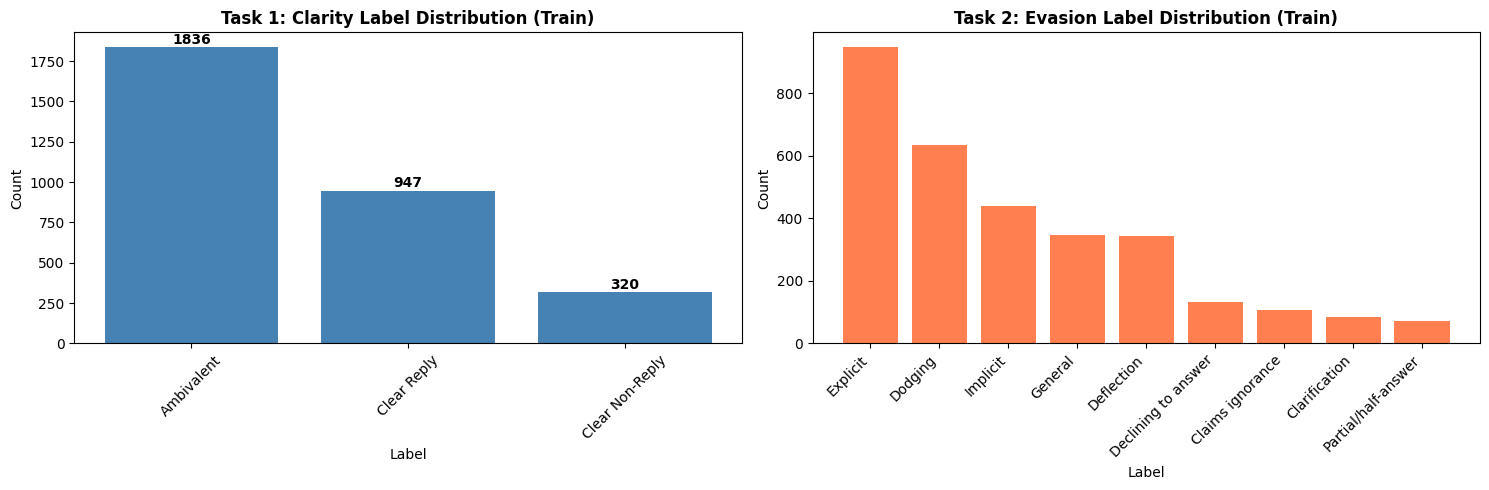

In [5]:
# Visualize label distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Clarity distribution
clarity_counts = clarity_train_df['clarity_label'].value_counts()
axes[0].bar(clarity_counts.index, clarity_counts.values, color='steelblue')
axes[0].set_title('Task 1: Clarity Label Distribution (Train)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(clarity_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Evasion distribution
evasion_counts = evasion_train_df['evasion_label'].value_counts()
axes[1].bar(range(len(evasion_counts)), evasion_counts.values, color='coral')
axes[1].set_title('Task 2: Evasion Label Distribution (Train)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(evasion_counts)))
axes[1].set_xticklabels(evasion_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 4. Dataset & DataLoader Setup

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {len(tokenizer)}")

Tokenizer loaded: distilbert-base-uncased
Vocabulary size: 30522


In [7]:
class QEvasionDataset(Dataset):
    """PyTorch Dataset for QEvasion tasks."""

    def __init__(self, df, tokenizer, max_length, task='clarity'):
        """
        Args:
            df: DataFrame with text and labels
            tokenizer: HuggingFace tokenizer
            max_length: Maximum sequence length
            task: 'clarity', 'evasion', or 'multitask'
        """
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.task = task

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['text']

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

        # Add labels based on task
        if self.task == 'clarity':
            item['labels'] = torch.tensor(row['clarity_id'], dtype=torch.long)
        elif self.task == 'evasion':
            item['labels'] = torch.tensor(row['evasion_id'], dtype=torch.long)
        elif self.task == 'multitask':
            item['clarity_labels'] = torch.tensor(row['clarity_id'], dtype=torch.long)
            if 'evasion_id' in row and row['evasion_id'] != -1:
                item['evasion_labels'] = torch.tensor(row['evasion_id'], dtype=torch.long)
                item['evasion_mask'] = torch.tensor(1, dtype=torch.long)
            else:
                item['evasion_labels'] = torch.tensor(-1, dtype=torch.long)
                item['evasion_mask'] = torch.tensor(0, dtype=torch.long)

        return item

In [8]:
# Create DataLoaders for Task 1 (Clarity)
clarity_train_dataset = QEvasionDataset(clarity_train_df, tokenizer, MAX_LENGTH, task='clarity')
clarity_val_dataset = QEvasionDataset(clarity_val_df, tokenizer, MAX_LENGTH, task='clarity')
clarity_test_dataset = QEvasionDataset(clarity_test_df, tokenizer, MAX_LENGTH, task='clarity')

clarity_train_loader = DataLoader(clarity_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
clarity_val_loader = DataLoader(clarity_val_dataset, batch_size=BATCH_SIZE)
clarity_test_loader = DataLoader(clarity_test_dataset, batch_size=BATCH_SIZE)

print("Task 1 DataLoaders created:")
print(f"  Train batches: {len(clarity_train_loader)}")
print(f"  Val batches: {len(clarity_val_loader)}")
print(f"  Test batches: {len(clarity_test_loader)}")

Task 1 DataLoaders created:
  Train batches: 194
  Val batches: 22
  Test batches: 20


In [9]:
# Create DataLoaders for Task 2 (Evasion)
evasion_train_dataset = QEvasionDataset(evasion_train_df, tokenizer, MAX_LENGTH, task='evasion')
evasion_val_dataset = QEvasionDataset(evasion_val_df, tokenizer, MAX_LENGTH, task='evasion')

evasion_train_loader = DataLoader(evasion_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
evasion_val_loader = DataLoader(evasion_val_dataset, batch_size=BATCH_SIZE)

print("Task 2 DataLoaders created:")
print(f"  Train batches: {len(evasion_train_loader)}")
print(f"  Val batches: {len(evasion_val_loader)}")

Task 2 DataLoaders created:
  Train batches: 194
  Val batches: 22


## 5. Task 1: Clarity Classification

Train a transformer model to classify political responses into 3 clarity levels.

In [10]:
# Initialize Task 1 model
clarity_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(CLARITY_LABELS),
    id2label=ID_TO_CLARITY,
    label2id=CLARITY_TO_ID
).to(device)

# Setup optimizer and loss
clarity_optimizer = torch.optim.AdamW(clarity_model.parameters(), lr=LEARNING_RATE)
clarity_loss_fn = nn.CrossEntropyLoss()

# Early stopping
clarity_early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

print(f"\n{'='*60}")
print("TRAINING TASK 1: CLARITY CLASSIFICATION")
print(f"{'='*60}")
print(f"Model: {MODEL_NAME}")
print(f"Parameters: {sum(p.numel() for p in clarity_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in clarity_model.parameters() if p.requires_grad):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TRAINING TASK 1: CLARITY CLASSIFICATION
Model: distilbert-base-uncased
Parameters: 66,955,779
Trainable: 66,955,779


In [11]:
# Train Task 1
clarity_history = train_model(
    model=clarity_model,
    train_loader=clarity_train_loader,
    val_loader=clarity_val_loader,
    optimizer=clarity_optimizer,
    scheduler=None,
    clarity_loss_fn=clarity_loss_fn,
    evasion_loss_fn=clarity_loss_fn,  # Reuse for single-task
    device=device,
    num_epochs=NUM_EPOCHS,
    early_stopping=clarity_early_stopping,
    verbose=True,
    is_multitask=False
)


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.8993
Val Accuracy: 0.5913
Val Macro F1: 0.2477

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8444
Val Accuracy: 0.6435
Val Macro F1: 0.5455
Metric improved from 0.2477 to 0.5455

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.7238
Val Accuracy: 0.6464
Val Macro F1: 0.5645
Metric improved from 0.5455 to 0.5645

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.6069
Val Accuracy: 0.6203
Val Macro F1: 0.5979
Metric improved from 0.5645 to 0.5979

Epoch 5/5
------------------------------------------------------------
Train Loss: 0.5189
Val Accuracy: 0.6667
Val Macro F1: 0.6252
Metric improved from 0.5979 to 0.6252


In [12]:
# Evaluate Task 1 on test set
print(f"\n{'='*60}")
print("TASK 1: TEST SET EVALUATION")
print(f"{'='*60}\n")

clarity_test_metrics, clarity_test_preds, clarity_test_labels, clarity_test_logits = evaluate(
    clarity_model, clarity_test_loader, device, return_predictions=True
)

# Comprehensive metrics
evaluate_task1(
    y_true=clarity_test_labels,
    y_pred=clarity_test_preds,
    label_names=CLARITY_LABELS,
    verbose=True
)


TASK 1: TEST SET EVALUATION

TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.6299
Macro F1:          0.4965
Weighted F1:       0.6255
Macro Precision:   0.5413
Macro Recall:      0.4770

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.73      0.75      0.74       206
Clear Non-Reply       0.50      0.26      0.34        23
    Clear Reply       0.39      0.42      0.40        79

       accuracy                           0.63       308
      macro avg       0.54      0.48      0.50       308
   weighted avg       0.63      0.63      0.63       308



{'accuracy': 0.6298701298701299,
 'macro_f1': 0.49646397085854616,
 'weighted_f1': 0.6254823505334053,
 'macro_precision': 0.5413297394429469,
 'macro_recall': 0.4770060895569175}

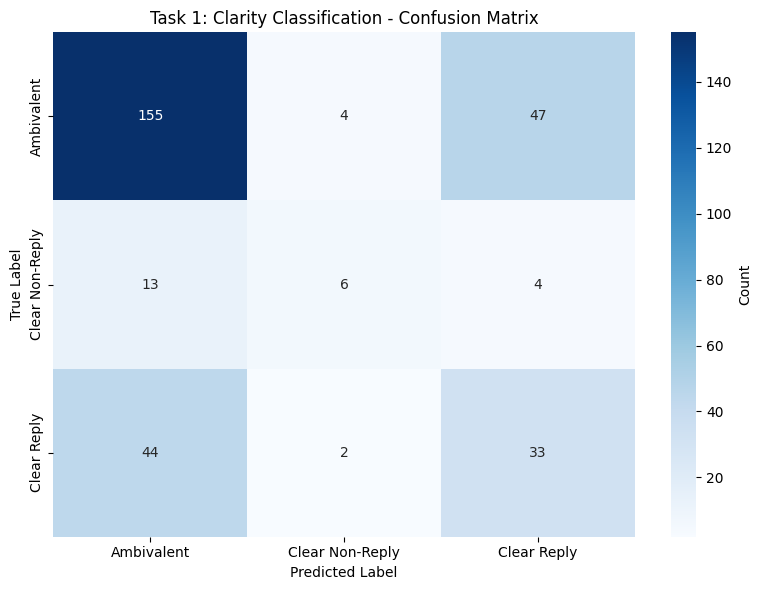

In [13]:
# Confusion matrix for Task 1
plot_confusion_matrix(
    y_true=clarity_test_labels,
    y_pred=clarity_test_preds,
    label_names=CLARITY_LABELS,
    title="Task 1: Clarity Classification - Confusion Matrix",
    figsize=(8, 6)
)

In [14]:
# Per-class metrics
per_class_df = compute_per_class_metrics(clarity_test_labels, clarity_test_preds, CLARITY_LABELS)
print("\nPer-Class Performance:")
print(per_class_df.to_string(index=False))


Per-Class Performance:
          Label  Support  Precision   Recall       F1
     Ambivalent      206   0.731132 0.752427 0.741627
Clear Non-Reply       23   0.500000 0.260870 0.342857
    Clear Reply       79   0.392857 0.417722 0.404908


## 6. Task 2: Evasion Classification

Train a transformer model to classify evasion types (9 classes).

**Note:** Test evaluation uses multi-annotator agreement - a prediction is correct if it matches ANY annotator label.

In [15]:
# Initialize Task 2 model
evasion_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(EVASION_LABELS),
    id2label=ID_TO_EVASION,
    label2id=EVASION_TO_ID
).to(device)

# Setup optimizer and loss (use Focal Loss for imbalanced classes)
evasion_optimizer = torch.optim.AdamW(evasion_model.parameters(), lr=LEARNING_RATE)
evasion_loss_fn = FocalLoss(gamma=2.0)  # Helps with class imbalance

# Early stopping
evasion_early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

print(f"\n{'='*60}")
print("TRAINING TASK 2: EVASION CLASSIFICATION")
print(f"{'='*60}")
print(f"Model: {MODEL_NAME}")
print(f"Loss Function: Focal Loss (gamma=2.0) - helps with class imbalance")
print(f"Parameters: {sum(p.numel() for p in evasion_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in evasion_model.parameters() if p.requires_grad):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TRAINING TASK 2: EVASION CLASSIFICATION
Model: distilbert-base-uncased
Loss Function: Focal Loss (gamma=2.0) - helps with class imbalance
Parameters: 66,960,393
Trainable: 66,960,393


In [16]:
# Train Task 2
evasion_history = train_model(
    model=evasion_model,
    train_loader=evasion_train_loader,
    val_loader=evasion_val_loader,
    optimizer=evasion_optimizer,
    scheduler=None,
    clarity_loss_fn=evasion_loss_fn,
    evasion_loss_fn=evasion_loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    early_stopping=evasion_early_stopping,
    verbose=True,
    is_multitask=False
)


Epoch 1/5
------------------------------------------------------------
Train Loss: 1.8858
Val Accuracy: 0.2928
Val Macro F1: 0.0677

Epoch 2/5
------------------------------------------------------------
Train Loss: 1.7783
Val Accuracy: 0.3275
Val Macro F1: 0.1402
Metric improved from 0.0677 to 0.1402

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.6213
Val Accuracy: 0.3449
Val Macro F1: 0.2460
Metric improved from 0.1402 to 0.2460

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.4294
Val Accuracy: 0.3739
Val Macro F1: 0.3377
Metric improved from 0.2460 to 0.3377

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.2508
Val Accuracy: 0.3362
Val Macro F1: 0.3356
No improvement for 1 epoch(s)


In [17]:
# Evaluate Task 2 on validation set (standard single-label)
print(f"\n{'='*60}")
print("TASK 2: VALIDATION SET EVALUATION")
print(f"{'='*60}\n")

evasion_test_metrics, evasion_test_preds, evasion_test_labels, _ = evaluate(
    evasion_model, evasion_val_loader, device, return_predictions=True
)

evaluate_task2_standard(
    y_true=evasion_test_labels,
    y_pred=evasion_test_preds,
    label_names=EVASION_LABELS,
    verbose=True
)


TASK 2: VALIDATION SET EVALUATION

TASK 2: EVASION CLASSIFICATION (Single Label)
Accuracy:          0.3362
Macro F1:          0.3356
Weighted F1:       0.3214
Macro Precision:   0.3444
Macro Recall:      0.3441

Classification Report:
                     precision    recall  f1-score   support

   Claims ignorance       0.43      0.50      0.46        12
      Clarification       0.80      0.89      0.84         9
Declining to answer       0.45      0.36      0.40        14
         Deflection       0.31      0.13      0.19        38
            Dodging       0.29      0.49      0.36        71
           Explicit       0.43      0.41      0.42       105
            General       0.19      0.15      0.17        39
           Implicit       0.20      0.16      0.18        49
Partial/half-answer       0.00      0.00      0.00         8

           accuracy                           0.34       345
          macro avg       0.34      0.34      0.34       345
       weighted avg       0.33

{'accuracy': 0.336231884057971,
 'macro_f1': 0.3355660356196182,
 'weighted_f1': 0.32136707090934014,
 'macro_precision': 0.34436511044863366,
 'macro_recall': 0.34413374548571696}

### Task 2: Test Set Evaluation (Multi-Annotator)

The test set uses 3 annotators. A prediction is correct if it matches **ANY** annotator's label.

In [18]:
# Prepare test data for evasion (only examples with annotator labels)
test_evasion_with_labels = evasion_test_df[
    evasion_test_df['annotator_labels'].apply(len) > 0
].reset_index(drop=True)

print(f"Test examples with annotator labels: {len(test_evasion_with_labels)}")
print(f"Total test examples: {len(evasion_test_df)}")

# Create test dataset (use dummy labels since we'll compare to annotator sets)
test_evasion_dataset = QEvasionDataset(
    test_evasion_with_labels.assign(evasion_id=0),  # Dummy label
    tokenizer,
    MAX_LENGTH,
    task='evasion'
)
test_evasion_loader = DataLoader(test_evasion_dataset, batch_size=BATCH_SIZE)

Test examples with annotator labels: 308
Total test examples: 308


In [19]:
# Get predictions from model
evasion_model.eval()
test_pred_ids = []

with torch.no_grad():
    for batch in test_evasion_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = evasion_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_pred_ids.extend(preds.cpu().numpy())

# Convert predictions to label strings
test_pred_labels = [ID_TO_EVASION[pred_id] for pred_id in test_pred_ids]

# Get gold label sets (from annotators)
gold_label_sets = test_evasion_with_labels['annotator_labels'].tolist()

print(f"\n{'='*60}")
print("TASK 2: TEST SET EVALUATION (MULTI-ANNOTATOR)")
print(f"{'='*60}\n")

# Evaluate with multi-annotator metric
task2_test_metrics = evaluate_task2_multi_annotator(
    y_pred=test_pred_labels,
    gold_sets=gold_label_sets,
    verbose=True
)


TASK 2: TEST SET EVALUATION (MULTI-ANNOTATOR)

TASK 2: EVASION CLASSIFICATION (Multi-Annotator)
Total examples:    308
Correct:           124
Accuracy:          0.4026

Note: Prediction counted as correct if it matches ANY annotator.


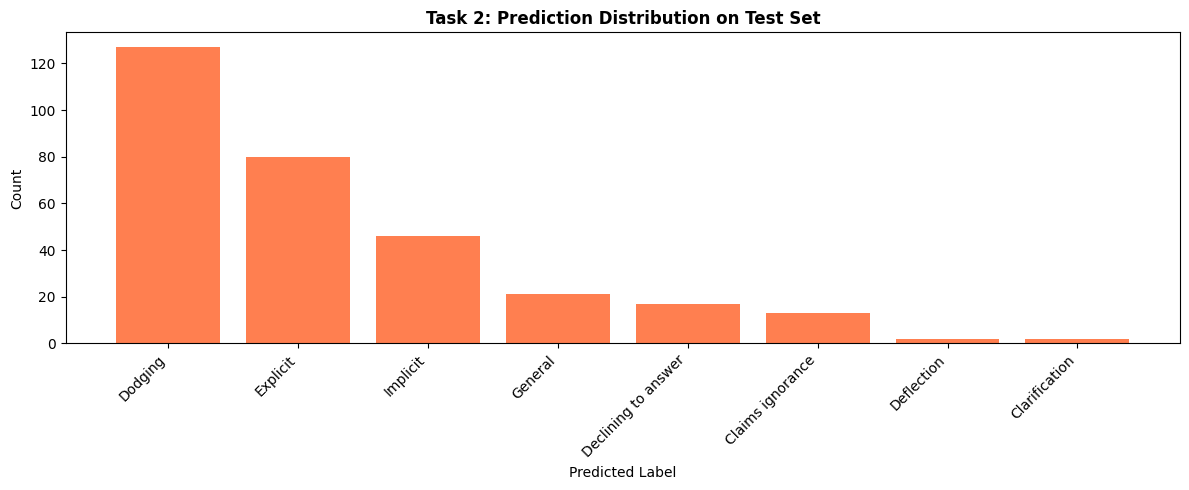


Test Set Prediction Counts:
Dodging                127
Explicit                80
Implicit                46
General                 21
Declining to answer     17
Claims ignorance        13
Deflection               2
Clarification            2
Name: count, dtype: int64


In [20]:
# Analyze prediction distribution
pred_dist = pd.Series(test_pred_labels).value_counts()

plt.figure(figsize=(12, 5))
plt.bar(range(len(pred_dist)), pred_dist.values, color='coral')
plt.title('Task 2: Prediction Distribution on Test Set', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks(range(len(pred_dist)), pred_dist.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nTest Set Prediction Counts:")
print(pred_dist)

## 6.5. Two-Step Classification: Evasion to Clarity

The paper (Table 3) shows that classifying evasion first, then mapping to clarity
often achieves **better or comparable performance** to direct clarity classification.

**Strategy:**
1. Use the Task 2 model (9-way evasion classifier)
2. Get predictions on Task 1 test data
3. Map evasion labels to clarity labels
4. Evaluate as clarity task
5. Compare with direct clarity results

**Why this works:**
- Fine-grained evasion labels provide more nuanced understanding
- Mapping preserves the hierarchical taxonomy structure
- Model learns richer representations from 9-way task

TWO-STEP CLASSIFICATION: EVASION → CLARITY

1. Loading Task 1 test data...
✓ Task 1 test samples: 308

2. Creating DataLoader...

3. Getting evasion predictions...


Predicting: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]


✓ Got 308 predictions

4. Evaluating evasion-based clarity...
EVASION-BASED CLARITY CLASSIFICATION
Accuracy:          0.5844
Macro F1:          0.4871
Weighted F1:       0.5893
Macro Precision:   0.4735
Macro Recall:      0.5083

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.71      0.68      0.70       206
Clear Non-Reply       0.34      0.48      0.40        23
    Clear Reply       0.36      0.37      0.36        79

       accuracy                           0.58       308
      macro avg       0.47      0.51      0.49       308
   weighted avg       0.60      0.58      0.59       308


5. Manual mapping demonstration...
Mapping examples:
  Dodging              → Ambivalent
  Implicit             → Ambivalent
  Dodging              → Ambivalent
  Claims ignorance     → Clear Non-Reply
  Explicit             → Clear Reply

STRATEGY COMPARISON

      Metric  Direct Clarity  Evasion-Based  Difference
   Accuracy        0.629870

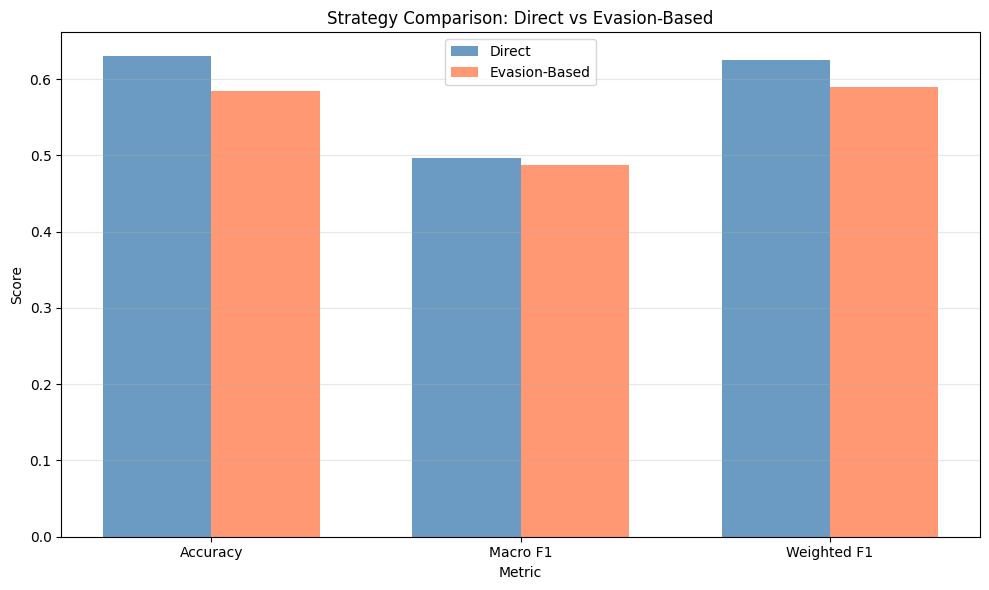


→ Direct clarity performs better


In [21]:
print("=" * 80)
print("TWO-STEP CLASSIFICATION: EVASION → CLARITY")
print("=" * 80)

# 1. Load Task 1 test data for clarity ground truth
print("\n1. Loading Task 1 test data...")
_, _, clarity_test_df = prepare_task1_data(dataset, val_size=0.1, random_state=42)
print(f"✓ Task 1 test samples: {len(clarity_test_df)}")

# 2. Create DataLoader
print("\n2. Creating DataLoader...")
clarity_test_dataset = QEvasionDataset(
    clarity_test_df,
    tokenizer,
    MAX_LENGTH,
    task='evasion'
)
clarity_test_loader = DataLoader(
    clarity_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 3. Get evasion predictions
print("\n3. Getting evasion predictions...")
evasion_model.eval()
evasion_predictions = []

with torch.no_grad():
    for batch in tqdm(clarity_test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = evasion_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        evasion_predictions.extend(preds.cpu().numpy())

evasion_predictions = np.array(evasion_predictions)
print(f"✓ Got {len(evasion_predictions)} predictions")

# 4. Evaluate evasion-based clarity (automatic)
print("\n4. Evaluating evasion-based clarity...")
evasion_clarity_metrics = evaluate_evasion_based_clarity(
    evasion_preds=evasion_predictions,
    clarity_true=clarity_test_df['clarity_id'].values,
    evasion_label_names=EVASION_LABELS,
    clarity_label_names=CLARITY_LABELS,
    verbose=True
)

# 5. Manual mapping (optional, for understanding)
print("\n5. Manual mapping demonstration...")
clarity_predictions_from_evasion = map_evasion_ids_to_clarity_ids(evasion_predictions)
print("Mapping examples:")
for i in range(min(5, len(evasion_predictions))):
    print(f"  {ID_TO_EVASION[evasion_predictions[i]]:20} → {ID_TO_CLARITY[clarity_predictions_from_evasion[i]]}")

# 6. Compare strategies
print("\n" + "=" * 80)
print("STRATEGY COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1', 'Weighted F1'],
    'Direct Clarity': [
        clarity_test_metrics['accuracy'],
        clarity_test_metrics['macro_f1'],
        clarity_test_metrics['weighted_f1']
    ],
    'Evasion-Based': [
        evasion_clarity_metrics['accuracy'],
        evasion_clarity_metrics['macro_f1'],
        evasion_clarity_metrics['weighted_f1']
    ]
})
comparison_df['Difference'] = comparison_df['Evasion-Based'] - comparison_df['Direct Clarity']

print("\n", comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35
ax.bar(x - width/2, comparison_df['Direct Clarity'], width, label='Direct', color='steelblue', alpha=0.8)
ax.bar(x + width/2, comparison_df['Evasion-Based'], width, label='Evasion-Based', color='coral', alpha=0.8)
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Strategy Comparison: Direct vs Evasion-Based')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusion
if evasion_clarity_metrics['macro_f1'] > clarity_test_metrics['macro_f1']:
    print(f"\n✓ Evasion-based WINS by +{(evasion_clarity_metrics['macro_f1'] - clarity_test_metrics['macro_f1']) * 100:.2f}% F1")
else:
    print(f"\n→ Direct clarity performs better")

print("=" * 80)

## 7. Multi-Task Learning

Train a single model that learns both clarity and evasion classification simultaneously.

In [22]:
# Create multi-task datasets
mt_train_dataset = QEvasionDataset(clarity_train_df, tokenizer, MAX_LENGTH, task='multitask')
mt_val_dataset = QEvasionDataset(clarity_val_df, tokenizer, MAX_LENGTH, task='multitask')

mt_train_loader = DataLoader(mt_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mt_val_loader = DataLoader(mt_val_dataset, batch_size=BATCH_SIZE)

print("Multi-Task DataLoaders created:")
print(f"  Train batches: {len(mt_train_loader)}")
print(f"  Val batches: {len(mt_val_loader)}")

Multi-Task DataLoaders created:
  Train batches: 194
  Val batches: 22


In [23]:
# Initialize multi-task model
mt_model = MultiTaskTransformer(
    model_name=MODEL_NAME,
    num_clarity_labels=len(CLARITY_LABELS),
    num_evasion_labels=len(EVASION_LABELS),
    dropout_rate=0.1
).to(device)

# Setup optimizer and losses
mt_optimizer = torch.optim.AdamW(mt_model.parameters(), lr=LEARNING_RATE)
mt_clarity_loss = nn.CrossEntropyLoss()
mt_evasion_loss = FocalLoss(gamma=2.0)  # Handle imbalance in evasion task

# Early stopping
mt_early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

print(f"\n{'='*60}")
print("TRAINING MULTI-TASK MODEL")
print(f"{'='*60}")
print(f"Model: {MODEL_NAME} (shared encoder)")
print(f"Clarity Head: {len(CLARITY_LABELS)} classes")
print(f"Evasion Head: {len(EVASION_LABELS)} classes")
print(f"Total Parameters: {sum(p.numel() for p in mt_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in mt_model.parameters() if p.requires_grad):,}")


TRAINING MULTI-TASK MODEL
Model: distilbert-base-uncased (shared encoder)
Clarity Head: 3 classes
Evasion Head: 9 classes
Total Parameters: 66,372,108
Trainable: 66,372,108


In [24]:
# Train multi-task model
mt_history = train_model(
    model=mt_model,
    train_loader=mt_train_loader,
    val_loader=mt_val_loader,
    optimizer=mt_optimizer,
    scheduler=None,
    clarity_loss_fn=mt_clarity_loss,
    evasion_loss_fn=mt_evasion_loss,
    device=device,
    num_epochs=NUM_EPOCHS,
    early_stopping=mt_early_stopping,
    verbose=True,
    is_multitask=True
)


Epoch 1/5
------------------------------------------------------------
Train Loss: 2.2324
Val Accuracy: 0.6203
Val Macro F1: 0.3267

Epoch 2/5
------------------------------------------------------------
Train Loss: 2.0436
Val Accuracy: 0.6406
Val Macro F1: 0.5049
Metric improved from 0.3267 to 0.5049

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.7545
Val Accuracy: 0.6522
Val Macro F1: 0.5894
Metric improved from 0.5049 to 0.5894

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.4977
Val Accuracy: 0.6464
Val Macro F1: 0.6007
Metric improved from 0.5894 to 0.6007

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.2741
Val Accuracy: 0.6435
Val Macro F1: 0.5994
No improvement for 1 epoch(s)


In [25]:
# Evaluate multi-task model
print(f"\n{'='*60}")
print("MULTI-TASK MODEL: VALIDATION EVALUATION")
print(f"{'='*60}\n")

mt_val_metrics = evaluate_multitask(mt_model, mt_val_loader, device)

print("Clarity Task:")
print(f"  Accuracy: {mt_val_metrics['clarity_accuracy']:.4f}")
print(f"  Macro F1: {mt_val_metrics['clarity_macro_f1']:.4f}")
print(f"  Weighted F1: {mt_val_metrics['clarity_weighted_f1']:.4f}")

if 'evasion_accuracy' in mt_val_metrics:
    print("\nEvasion Task:")
    print(f"  Accuracy: {mt_val_metrics['evasion_accuracy']:.4f}")
    print(f"  Macro F1: {mt_val_metrics['evasion_macro_f1']:.4f}")
    print(f"  Weighted F1: {mt_val_metrics['evasion_weighted_f1']:.4f}")


MULTI-TASK MODEL: VALIDATION EVALUATION

Clarity Task:
  Accuracy: 0.6435
  Macro F1: 0.5994
  Weighted F1: 0.6326

Evasion Task:
  Accuracy: 0.3652
  Macro F1: 0.3367
  Weighted F1: 0.3537


## 8. Training History Visualization

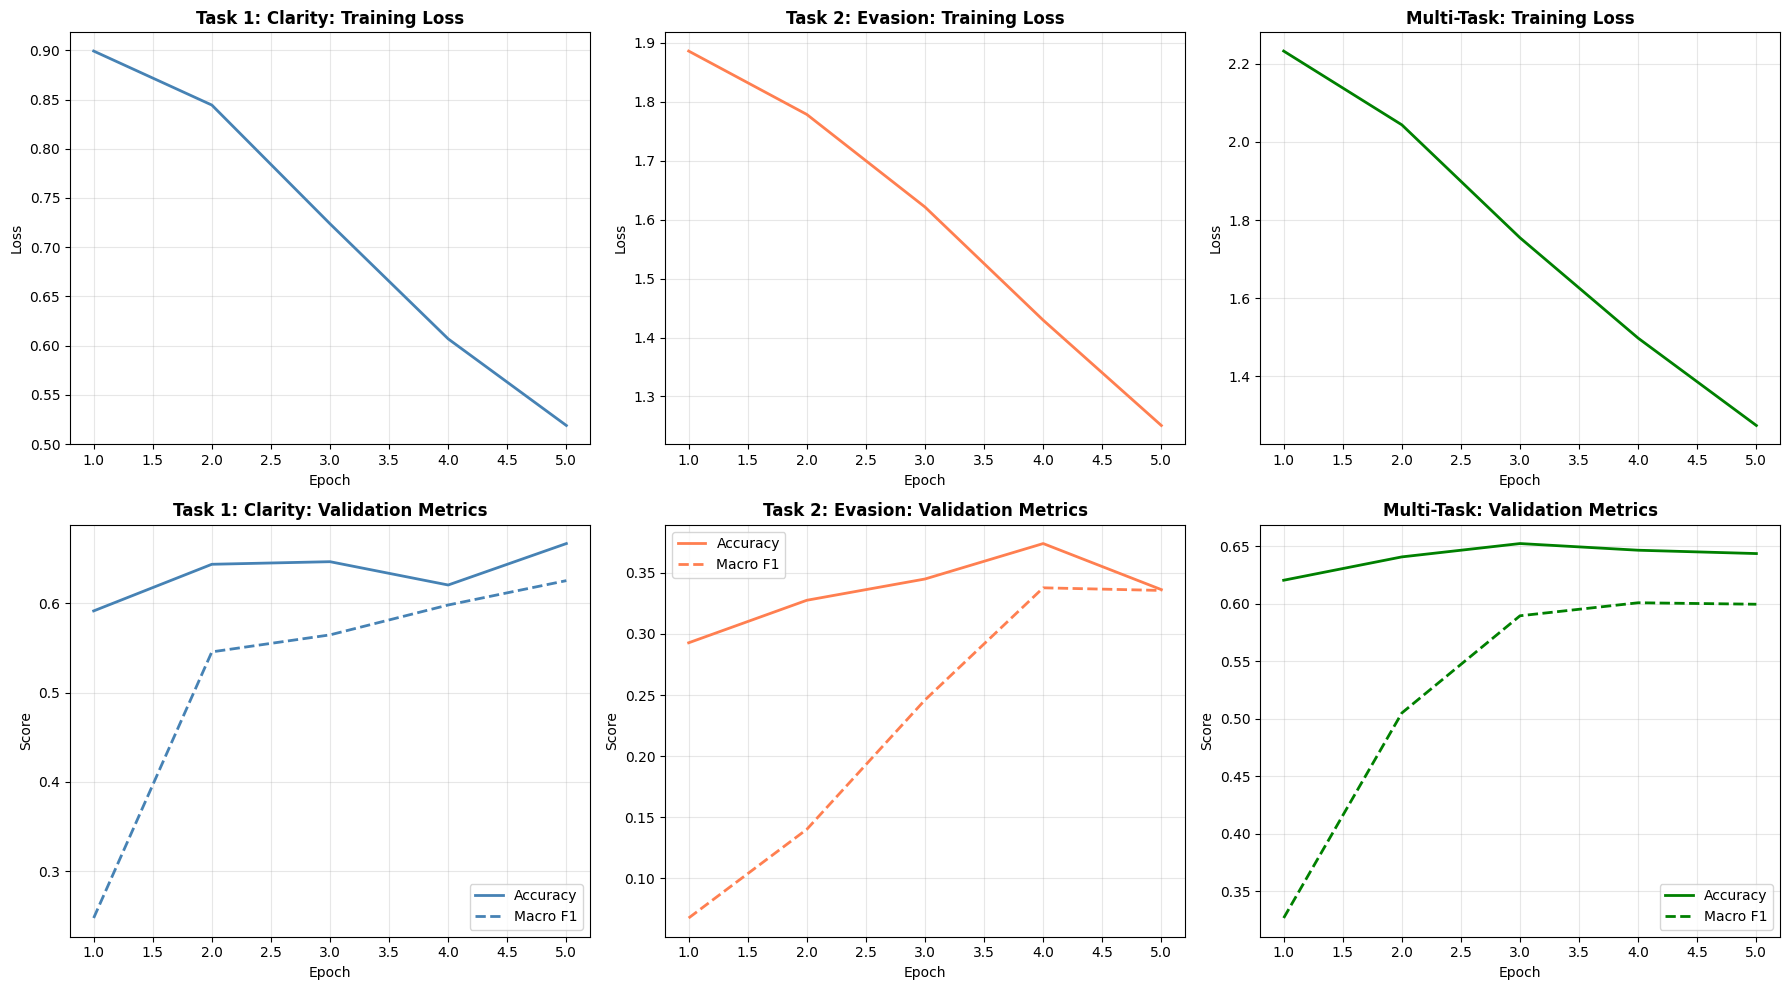

In [26]:
# Plot training histories
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [
    (clarity_history, 'Task 1: Clarity', 'steelblue'),
    (evasion_history, 'Task 2: Evasion', 'coral'),
    (mt_history, 'Multi-Task', 'green')
]

for idx, (history, title, color) in enumerate(histories):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0, idx].plot(epochs, history['train_loss'], color=color, linewidth=2)
    axes[0, idx].set_title(f'{title}: Training Loss', fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].grid(True, alpha=0.3)

    # Metrics plot
    axes[1, idx].plot(epochs, history['val_accuracy'], label='Accuracy', color=color, linewidth=2)
    axes[1, idx].plot(epochs, history['val_macro_f1'], label='Macro F1', color=color,
                     linestyle='--', linewidth=2)
    axes[1, idx].set_title(f'{title}: Validation Metrics', fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Score')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Final Results Summary

In [27]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print("\n📊 TASK 1: CLARITY CLASSIFICATION (Test Set)")
print("-" * 70)
print(f"  Accuracy:     {clarity_test_metrics['accuracy']:.4f}")
print(f"  Macro F1:     {clarity_test_metrics['macro_f1']:.4f}")
print(f"  Weighted F1:  {clarity_test_metrics['weighted_f1']:.4f}")
print(f"  Baseline:     {majority_baseline_accuracy(clarity_train_df['clarity_id'].values, clarity_test_df['clarity_id'].values):.4f}")

print("\n📊 TASK 2: EVASION CLASSIFICATION (Test Set, Multi-Annotator)")
print("-" * 70)
print(f"  Accuracy (any annotator): {task2_test_metrics['accuracy_any_annotator']:.4f}")
print(f"  Test examples:            {len(test_evasion_with_labels)}")

print("\n📊 MULTI-TASK MODEL (Validation Set)")
print("-" * 70)
print(f"  Clarity Accuracy:  {mt_val_metrics['clarity_accuracy']:.4f}")
print(f"  Clarity Macro F1:  {mt_val_metrics['clarity_macro_f1']:.4f}")
if 'evasion_accuracy' in mt_val_metrics:
    print(f"  Evasion Accuracy:  {mt_val_metrics['evasion_accuracy']:.4f}")
    print(f"  Evasion Macro F1:  {mt_val_metrics['evasion_macro_f1']:.4f}")


FINAL RESULTS SUMMARY

📊 TASK 1: CLARITY CLASSIFICATION (Test Set)
----------------------------------------------------------------------
  Accuracy:     0.6299
  Macro F1:     0.4965
  Weighted F1:  0.6255
  Baseline:     0.6688

📊 TASK 2: EVASION CLASSIFICATION (Test Set, Multi-Annotator)
----------------------------------------------------------------------
  Accuracy (any annotator): 0.4026
  Test examples:            308

📊 MULTI-TASK MODEL (Validation Set)
----------------------------------------------------------------------
  Clarity Accuracy:  0.6435
  Clarity Macro F1:  0.5994
  Evasion Accuracy:  0.3652
  Evasion Macro F1:  0.3367


## 10. Model Comparison

Compare single-task vs multi-task approaches.

In [28]:
# Create comparison DataFrame
comparison_data = {
    'Model': ['Task 1 (Single)', 'Task 2 (Single)', 'Multi-Task'],
    'Clarity Acc': [
        clarity_test_metrics['accuracy'],
        '-',
        mt_val_metrics['clarity_accuracy']
    ],
    'Clarity F1': [
        clarity_test_metrics['macro_f1'],
        '-',
        mt_val_metrics['clarity_macro_f1']
    ],
    'Evasion Acc': [
        '-',
        task2_test_metrics['accuracy_any_annotator'],
        mt_val_metrics.get('evasion_accuracy', '-')
    ],
    'Parameters': [
        f"{sum(p.numel() for p in clarity_model.parameters()):,}",
        f"{sum(p.numel() for p in evasion_model.parameters()):,}",
        f"{sum(p.numel() for p in mt_model.parameters()):,}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
          Model Clarity Acc Clarity F1 Evasion Acc Parameters
Task 1 (Single)     0.62987   0.496464           - 66,955,779
Task 2 (Single)           -          -    0.402597 66,960,393
     Multi-Task    0.643478   0.599437    0.365217 66,372,108
